# k近傍法およびLoF(Local Outlier Factor) による時系列異常検知

### 必要なモジュールのimport

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors #k近傍法
from sklearn.neighbors import LocalOutlierFactor #LoF

### セグメントの切り出し関数

In [21]:
def segdata(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) #セグメントの切り出し，時系列反転，appendのための2次ベクトル化
        emb = np.append( emb, tmp, axis=0)
    return emb

### データ読み込み，パラメータ設定
 Keoghらの心電図のデータ  http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt
 Keogh, E., Lin, J. and Fu, A.: HOT SAX : Efficiently Finding the Most Unusual Time Series Subsequence, in Proceedings of the Fifth IEEE International Conference on Data Mining, ICDM 05, pp.226-233.

In [22]:
LEN=3000  #分析区間
WLEN=100 #セグメントのサイズ
SP=0         #学習用データの開始点
AP=3000   #テスト用データの開始点　個のデータの場合 4250ポイント付近に異常がある

No handles with labels found to put in legend.


データ数: 45000   次元数: 3


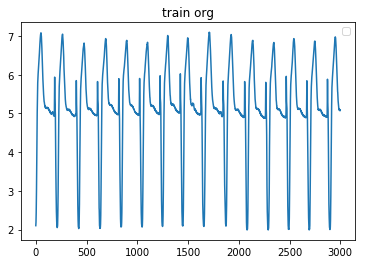

In [23]:
data = np.loadtxt("data/qtdbsel102.txt",delimiter="\t")
print("データ数:",data.shape[0],"  次元数:",data.shape[1])

#元データは3次元の時系列，3次のデータ(indexとしては2)を指定して学習/テストデータに分割
train_org = data[SP:SP+LEN, 2]      #学習用データとして 1～2999サンプル区間を使用
#学習データ
plt.title("train org")
x=np.arange(SP,SP+LEN)
plt.plot(x,train_org)
plt.legend()
plt.show()


### 窓関数の設定と切り出し

In [24]:
seglen = WLEN   #Window size
#winlenの単位で1ポイントずつずらした2次元表現に変換
train = segdata(train_org, seglen)


## k近傍学習（学習データ）

In [25]:
nk = 1#近傍数
knn = NearestNeighbors(n_neighbors=nk)
knn.fit(train)

NearestNeighbors(n_neighbors=1)

## LoF

In [26]:
lof = LocalOutlierFactor(n_neighbors=nk,
                           novelty=True,
                           contamination=0.1)
lof.fit(train) # train_dataは正常データが大多数であるような訓練データ

LocalOutlierFactor(contamination=0.1, n_neighbors=1, novelty=True)

## 未知データに対する評価

In [27]:
test_org  = data[AP:AP+LEN, 2]  #テスト用データとして3000～5999サンプルを使用
test =  segdata(test_org, seglen)





## knnの結果

In [28]:
# knn.fitで使った学習データを用いて最近傍距離(0次に格納される)を求める
dist = knn.kneighbors(test)[0]
anop_knn= np.argmax(dist)
# 最大距離で正規化しておく。つまり0～1.0にboundする。
dist= dist/np.max(dist)

## LoFの結果

In [29]:
# lof
prediction = lof.predict(test) # テストデータに対する予測
score = lof.score_samples(test) # テストデータの異常度
score=score/np.min(score)
anop_lof=np.argmax(score)

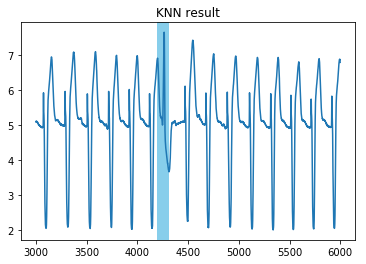

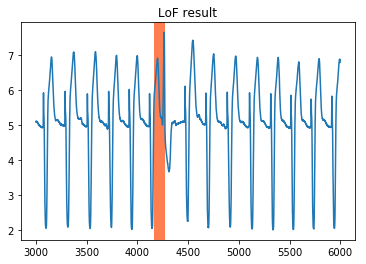

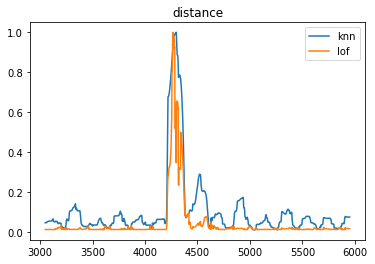

In [30]:


#テストデータ
plt.title("KNN result")
x=np.arange(AP,AP+LEN)
plt.axvspan(AP+anop_knn-WLEN/2, AP+anop_knn+WLEN/2, color = "skyblue")
plt.plot(x,test_org)
plt.show()

plt.title("LoF result")
plt.axvspan(AP+anop_lof-WLEN/2, AP+anop_lof+WLEN/2, color = "coral")
plt.plot(x,test_org)
plt.show()


#距離データ
plt.title("distance")
x=np.arange(AP+WLEN/2,AP+WLEN/2+len(dist))
plt.plot(x,dist,label="knn")
plt.plot(x,score,label="lof")
plt.legend()
plt.show()